In [1]:
import glob
import yaml
from IPython.display import Image, SVG, display, HTML
import py3Dmol

# Diffusion all the way down

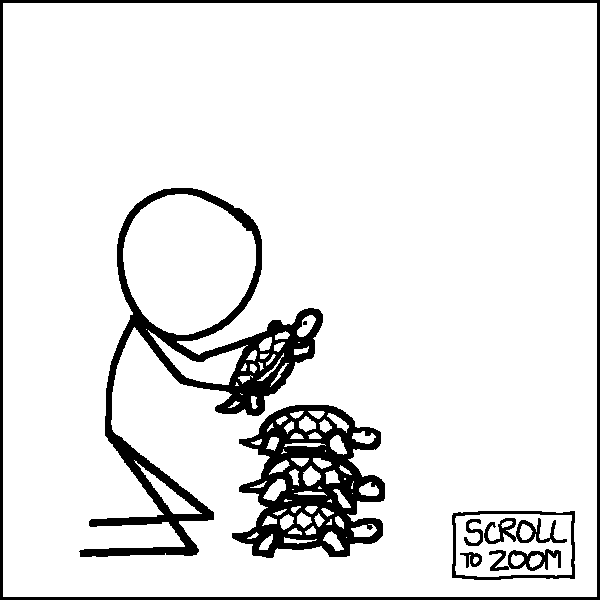

In [2]:
Image(filename="images/turtles_all_the_way_down.png")

# Sparsity is a huge limitation with protein-ligand complex data

And it is limiting our ability to pursue structure-based drug discovery in an open-sourced manner.

The entire PDB only contains ~200,000 structures the vast majority of which are co-crystallized with small molecules (N.B. these are not always drug-like).<sup>[1](https://www.rcsb.org/stats/)</sup>

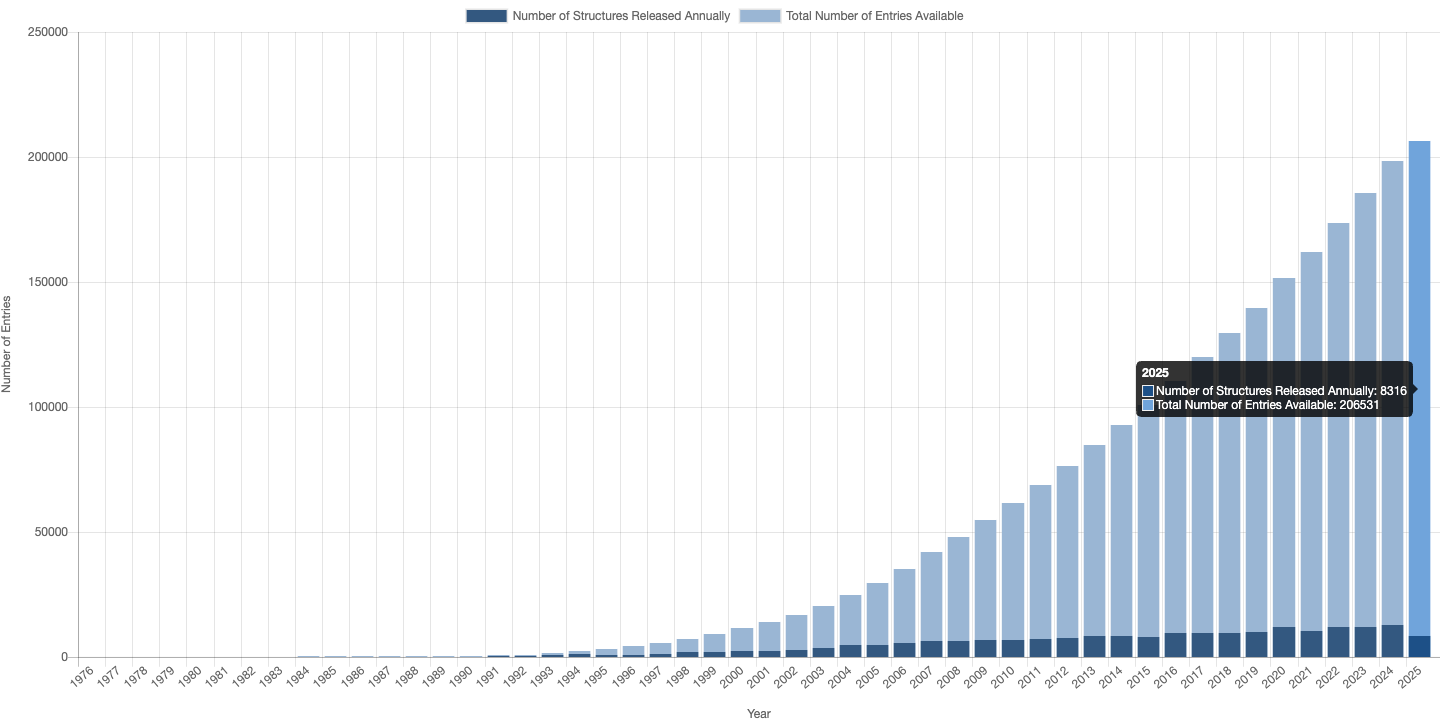

In [3]:
Image(filename="images/pdb_protein.png")

Far fewer complexes are annotated with affinity data. PDBbind, one of the few databases that has curated paired structural and affinity data, now requires a license. Their “standard refined set” contains 5,777 complexes, and an “expanded refined set” contains an additional 1,307 complexes.<sup>[2](https://www.pdbbind-plus.org.cn/)</sup>

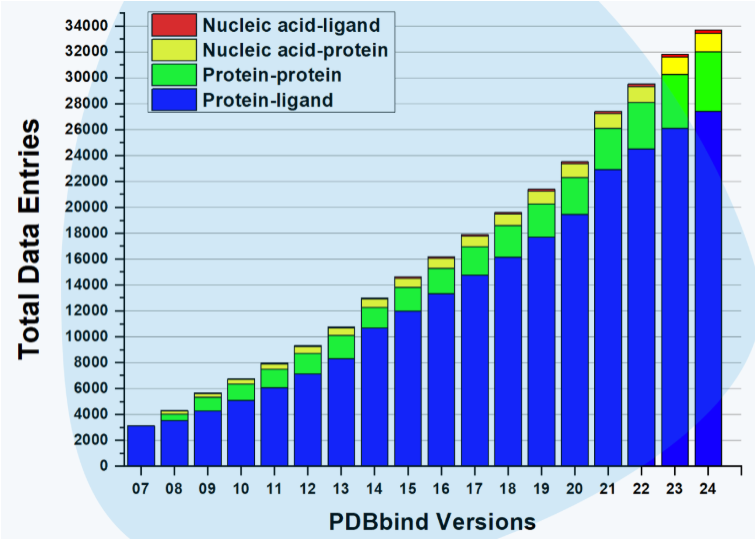

In [4]:
Image(filename="images/pdbbind.png")

# Diffusion in co-folding models

+ As a result, structure-based ML methods for protein function and ligand affinity lag behind structure prediction
+ The latest AlphaFold model (`AF3`) replaces its complex invariant point attention architecture with an all-atom diffusion-based method for final structure prediction
+ `AF3` and similar cofolding models, including `Boltz-1/2` and `Chai-1`, allow users to generate protein-ligand complexes

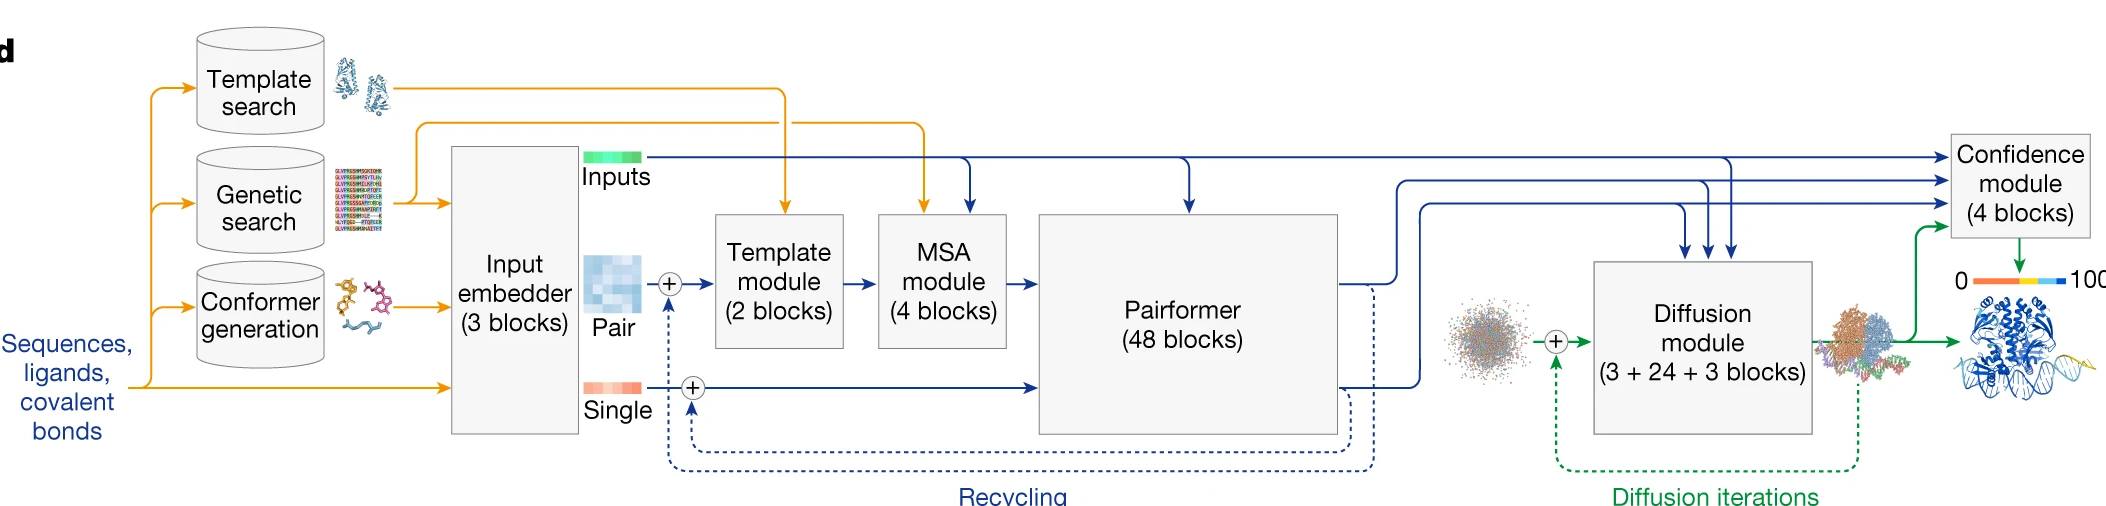

In [5]:
Image(filename="images/af3_fig1.png")

### **Illustrated AF<sup>([3](https://elanapearl.github.io/blog/2024/the-illustrated-alphafold/#triangle-attention))</sup>**

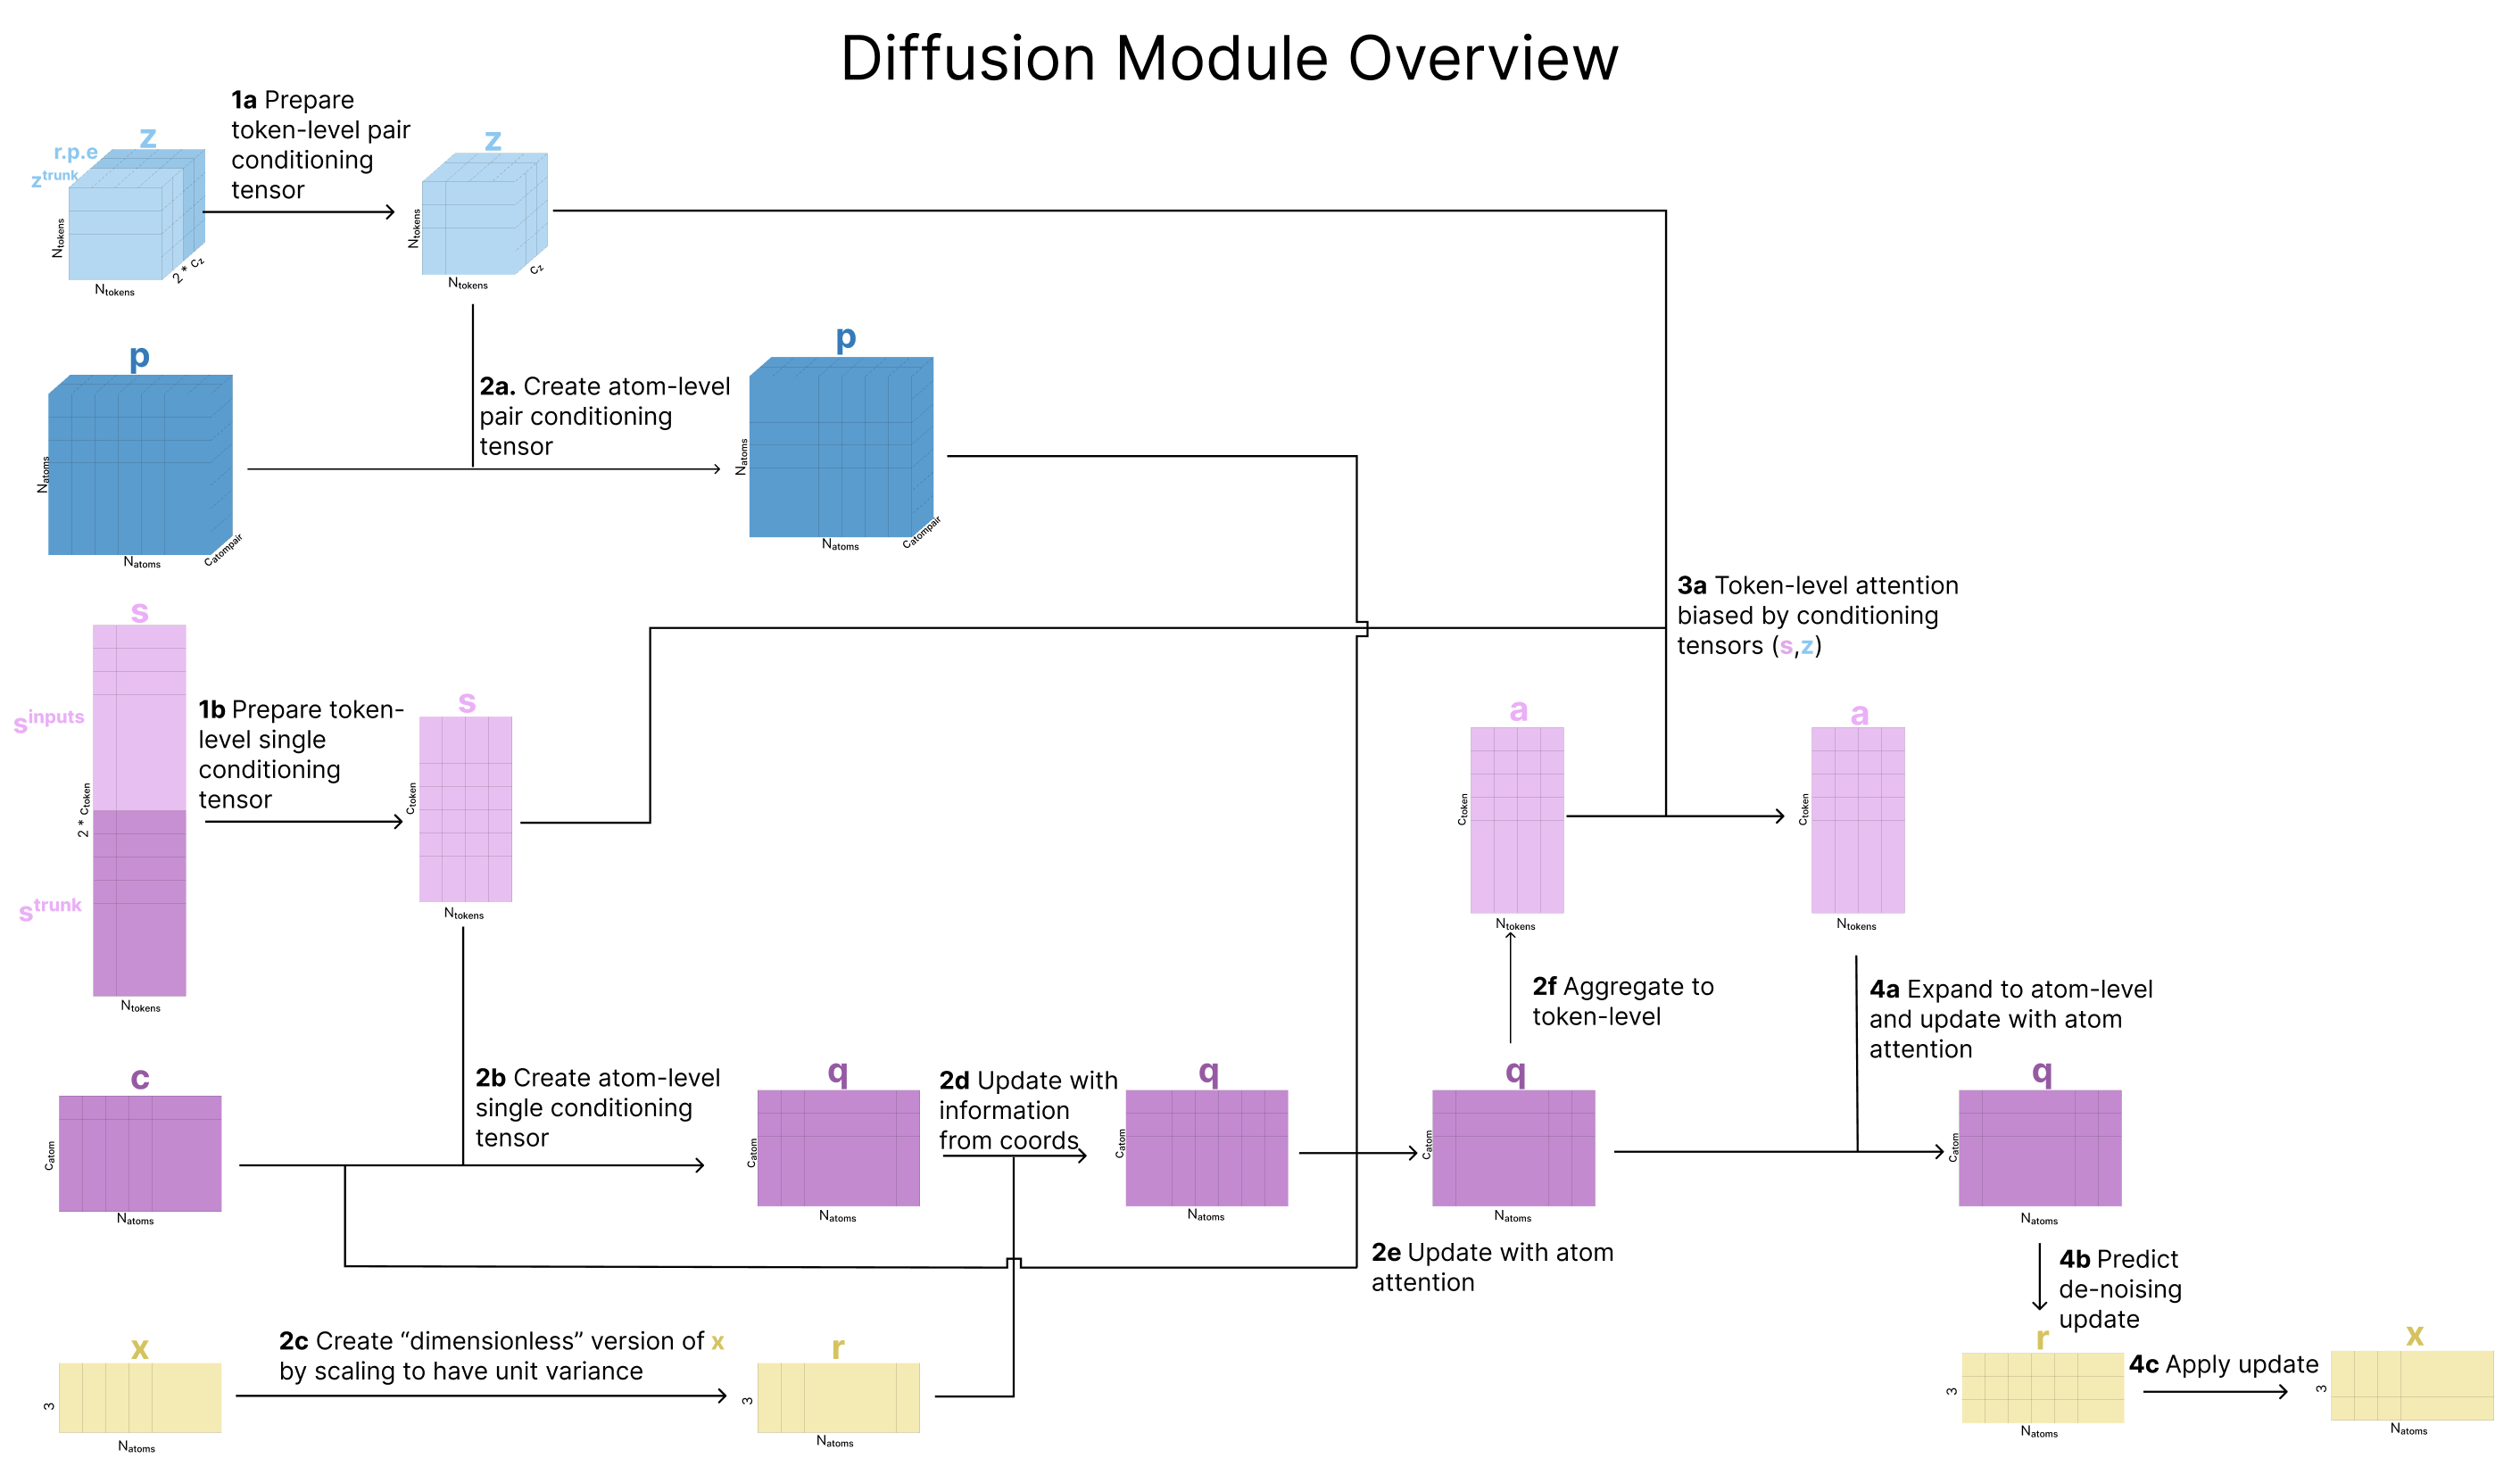

In [6]:
Image(filename="images/af_illustrated.png")

### **Algorithm 18: Sample Diffusion**

**Input:**  
$\{\mathbf{f}^*\}$, $\{\mathbf{s}_i^{\text{inputs}}\}$, $\{\mathbf{s}_i^{\text{trunk}}\}$, $\{\mathbf{z}_{ij}^{\text{trunk}}\}$, Noise Schedule $[c_0, c_1, \dots, c_T]$,  
$\gamma_0 = 0.8$, $\gamma_{\text{min}} = 1.0$, noise scale $\lambda = 1.003$, step scale $\eta = 1.5$

---

1. **Initialize**  
   $$
   \vec{x}_l \sim \mathcal{N}(0, \mathbb{I}_3)
   $$

2. **For all** $c_\tau \in [c_1, \dots, c_T]$:  
   - Perform Centre Random Augmentation (i.e., apply random translation and rotation to mean-centered vector):
     $$
     \{\vec{x}_l\} \leftarrow \text{CentreRandomAugmentation}(\{\vec{x}_l\})
     $$

   - Set $\gamma$:
     $$
     \gamma = \gamma_0 \quad \text{if} \quad c_\tau > \gamma_{\text{min}} \quad \text{else} \quad 0
     $$

   - Compute $t_\tau$:
     $$
     t_\tau = c_{\tau - 1} (\gamma + 1)
     $$

   - Compute noise:
     $$
     \xi_l = \lambda \sqrt{t_\tau^2 - c_{\tau - 1}^2} \cdot \mathcal{N}(0, \mathbb{I}_3)
     $$

   - Update noisy position:
     $$
     \vec{x}_l^{\text{noisy}} = \vec{x}_l + \xi_l
     $$

3. **Denosing Step:**  
   - Apply DiffusionModule:
     $$
     \{\vec{x}_l^{\text{denoised}}\} = \text{DiffusionModule}(\{\vec{x}_l^{\text{noisy}}\}, \hat{t}, \{\mathbf{f}^*\}, \{\mathbf{s}_i^{\text{inputs}}\}, \{\mathbf{s}_i^{\text{trunk}}\}, \{\mathbf{z}_{ij}^{\text{trunk}}\})
     $$

4. **Update Position:**
   $$
   \delta_l = \frac{(\vec{x}_l - \vec{x}_l^{\text{denoised}})}{t_\tau}
   $$

   - Compute the time step:
     $$
     dt = c_\tau - t_\tau
     $$

   - Update position:
     $$
     \vec{x}_l \leftarrow \vec{x}_l + \eta \cdot dt \cdot \delta_l
     $$

5. **End Loop**

---

**Return:** $\{\vec{x}_l\}$


### **Algorithm 20: Diffusion Module**

**Input:**  
$\{\vec{x}_l^{\text{noisy}}\}$, $\hat{t}$, $\{\mathbf{f}^*\}$, $\{\mathbf{s}_i^{\text{inputs}}\}$, $\{\mathbf{s}_i^{\text{trunk}}\}$, $\{\mathbf{z}_{ij}^{\text{trunk}}\}$  
$\sigma_{\text{data}} = 16$, $c_{\text{atom}} = 128$, $c_{\text{atompair}} = 16$, $c_{\text{token}} = 768$

---

1. **Conditioning**

   $$
   \{\mathbf{s}_i\}, \{\mathbf{z}_{ij}\} \gets \text{DiffusionConditioning}(\hat{t}, \{\mathbf{f}^*\}, \{\mathbf{s}_i^{\text{inputs}}\}, \{\mathbf{s}_i^{\text{trunk}}\}, \{\mathbf{z}_{ij}^{\text{trunk}}\}, \sigma_{\text{data}})
   $$

2. **Scale positions to dimensionless vectors with approximately unit variance**

   $$
   \mathbf{r}_l^{\text{noisy}} = \frac{\vec{x}_l^{\text{noisy}}}{\sqrt{\hat{t}^2 + \sigma_{\text{data}}^2}} \quad 
   $$

   where $\mathbf{r}_l^{\text{noisy}} \in \mathbb{R}^3$

4. **Sequence-local Atom Attention and aggregation to coarse-grained tokens**

   $$
   \{\mathbf{a}_i\}, \{\mathbf{q}_l^{\text{skip}}\}, \{\mathbf{c}_l^{\text{skip}}\}, \{\mathbf{p}_{lm}^{\text{skip}}\} \gets \text{AtomAttentionEncoder}(\{\mathbf{f}^*\}, \{\mathbf{r}_l^{\text{noisy}}\}, \{\mathbf{s}_i^{\text{trunk}}\}, \{\mathbf{z}_{ij}^{\text{trunk}}\}, c_{\text{atom}}, c_{\text{atompair}}, c_{\text{token}})
   $$

   where $\mathbf{a}_i \in \mathbb{R}^{c_{\text{token}}}$

5. **Full self-attention on token level**

   $$
   \mathbf{a}_i += \text{LinearNoBias}(\text{LayerNorm}(\mathbf{s}_i))
   $$

   $$
   \{\mathbf{a}_i\} \leftarrow \text{DiffusionTransformer}(\{\mathbf{a}_i\}, \{\mathbf{s}_i\}, \{\mathbf{z}_{ij}\}, \beta_{ij} = 0, N_{\text{block}} = 24, N_{\text{head}} = 16)
   $$

   $$
   \mathbf{a}_i \gets \text{LayerNorm}(\mathbf{a}_i)
   $$

6. **Broadcast token activations to atoms and run Sequence-local Atom Attention**

   $$
   \{\mathbf{r}_l^{\text{update}}\} = \text{AtomAttentionDecoder}(\{\mathbf{a}_i\}, \{\mathbf{q}_l^{\text{skip}}\}, \{\mathbf{c}_l^{\text{skip}}\}, \{\mathbf{p}_{lm}^{\text{skip}}\})
   $$

7. **Rescale updates to positions and combine with input positions**

   $$
   \vec{x}_l^{\text{out}} = \frac{\sigma_{\text{data}}^2}{\sigma_{\text{data}}^2 + \hat{t}^2} \cdot \vec{x}_l^{\text{noisy}} + \frac{\sigma_{\text{data}} \cdot \hat{t}}{\sqrt{\sigma_{\text{data}}^2 + \hat{t}^2}} \cdot \mathbf{r}_l^{\text{update}}
   $$

---

**Return:** $\{\vec{x}_l^{\text{out}}\}$


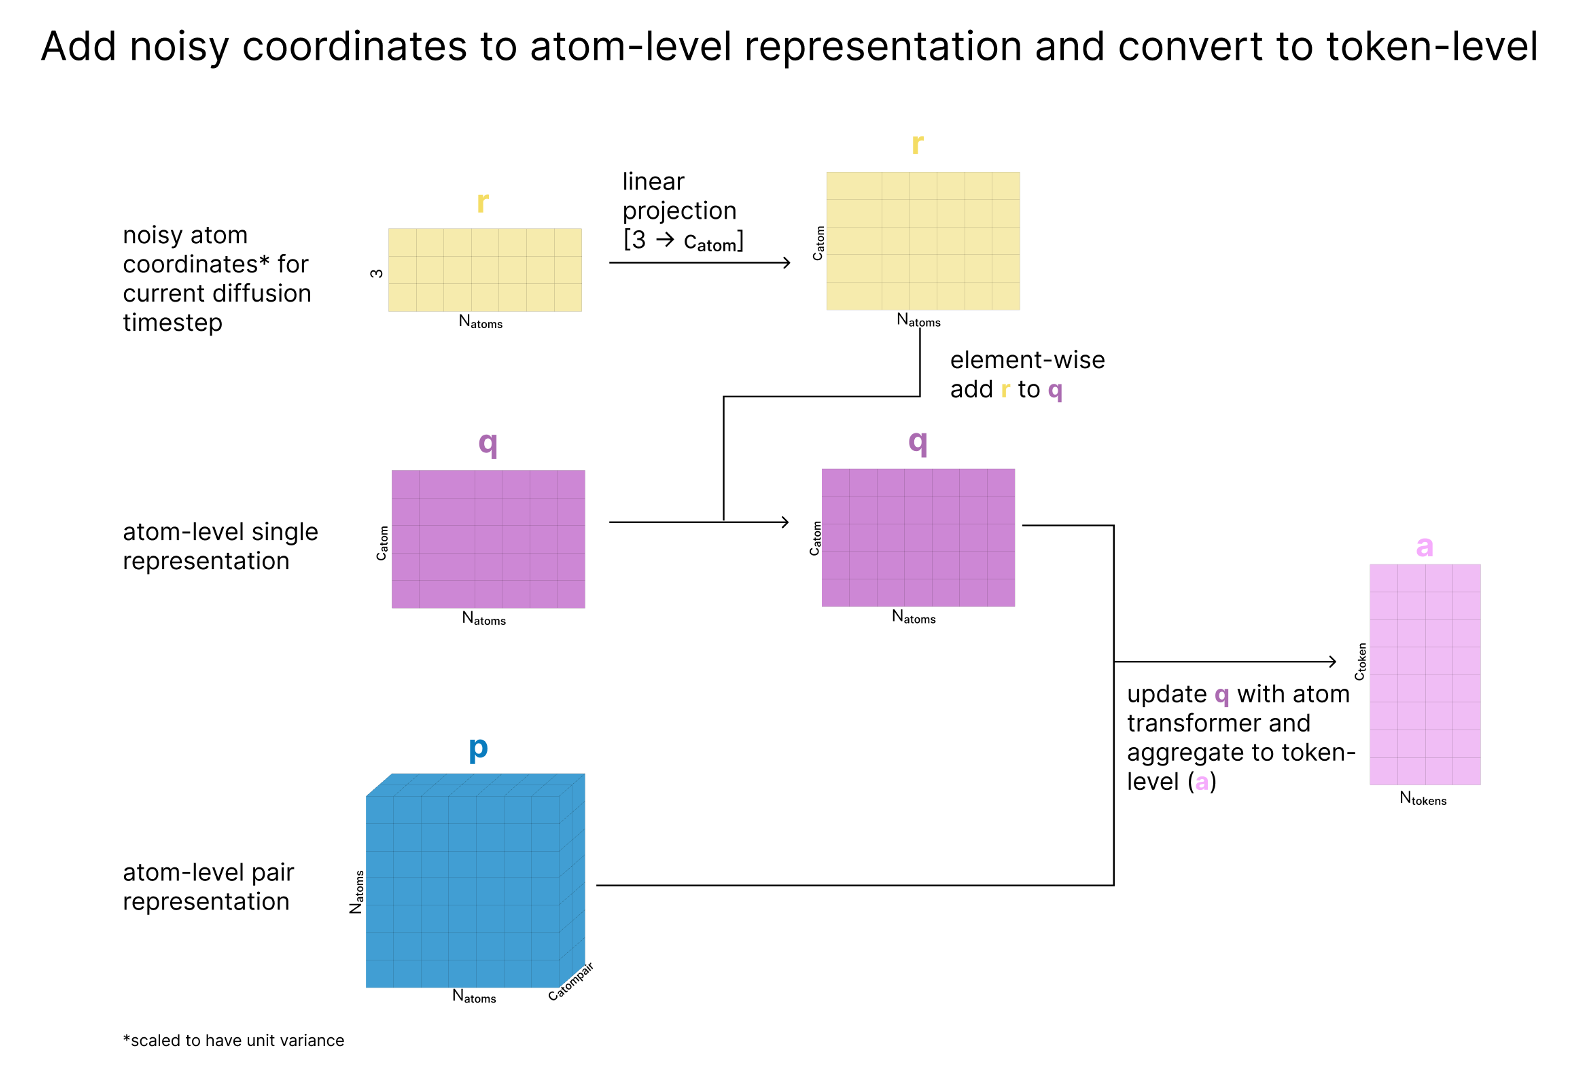

In [7]:
Image(filename="images/af3_20_a.png")

#### Apply attention at the token-level

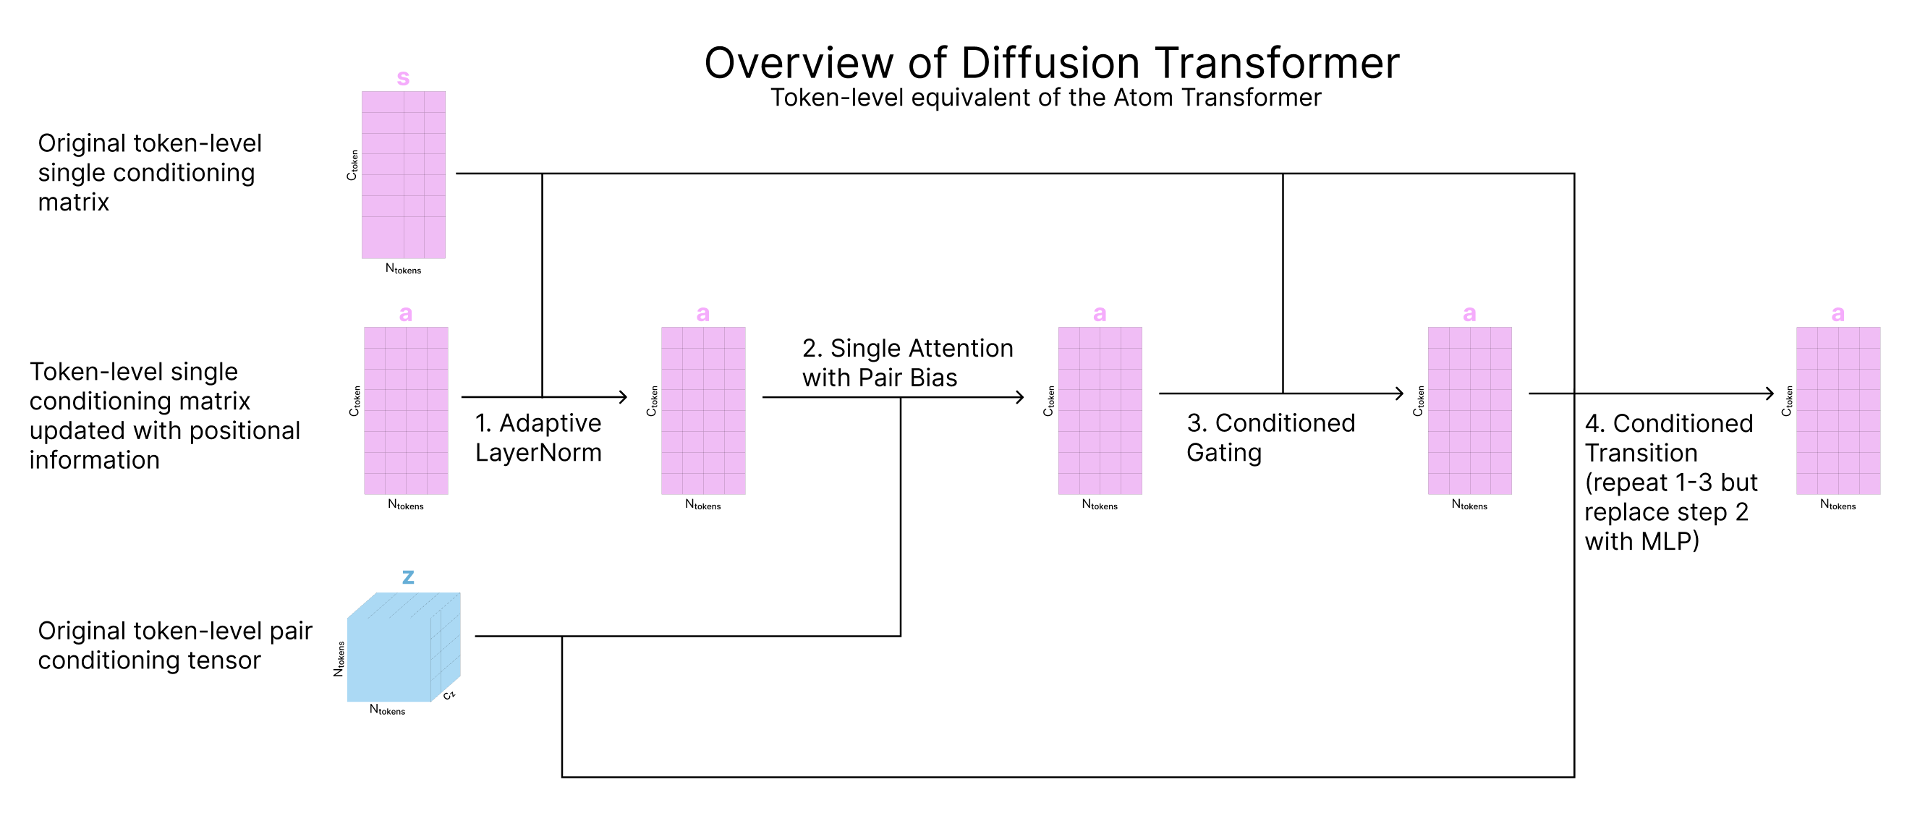

In [8]:
Image(filename="images/af3_20_b.png")

### **Algorithm 21: Diffusion Conditioning**

**Input:**  
$\hat{t}$, $\{\mathbf{f}^*\}$, $\{\mathbf{s}_i^{\text{inputs}}\}$, $\{\mathbf{s}_i^{\text{trunk}}\}$, $\{\mathbf{z}_{ij}^{\text{trunk}}\}$,  
$\sigma_{\text{data}} = 128$, $c_z = 128$, $c_s = 384$

---

1. **Pair conditioning**  
   $$
   \mathbf{z}_{ij} = \text{concat}([\mathbf{z}_{ij}^{\text{trunk}}, \text{RelativePositionEncoding}(\{\mathbf{f}^*\})])
   $$  
   $$
   \mathbf{z}_{ij} \gets \text{LinearNoBias}(\text{LayerNorm}(\mathbf{z}_{ij}))
   $$

2. **For** $b \in [1, 2]$ **do**  
   $$
   \mathbf{z}_{ij} += \text{Transition}(\mathbf{z}_{ij}, n = 2)
   $$  
   **end for**
> **Note:** In AF3 $\text{Transition}$ blocks contain $\text{AdaNorm}$ in lieu of $\text{LayerNorm}$ and $\text{SwiGLU}$ as the activation function.
---

3. **Single conditioning**  
   $$
   \mathbf{s}_i = \text{concat}([\mathbf{s}_i^{\text{trunk}}, \mathbf{s}_i^{\text{inputs}}])
   $$  
   $$
   \mathbf{s}_i \gets \text{LinearNoBias}(\text{LayerNorm}(\mathbf{s}_i))
   $$

4. **Compute Fourier embedding**  
   $$
   n = \text{FourierEmbedding}\left( \frac{1}{4} \log(\hat{t}/\sigma_{\text{data}}), 256 \right)
   $$  
   $$
   \mathbf{s}_i += \text{LinearNoBias}(\text{LayerNorm}(n))
   $$

5. **For** $b \in [1, 2]$ **do**  
   $$
   \mathbf{s}_i += \text{Transition}(\mathbf{s}_i, n = 2)
   $$  
   **end for**

---

**Return:** $\{\mathbf{s}_i\}, \{\mathbf{z}_{ij}\}$

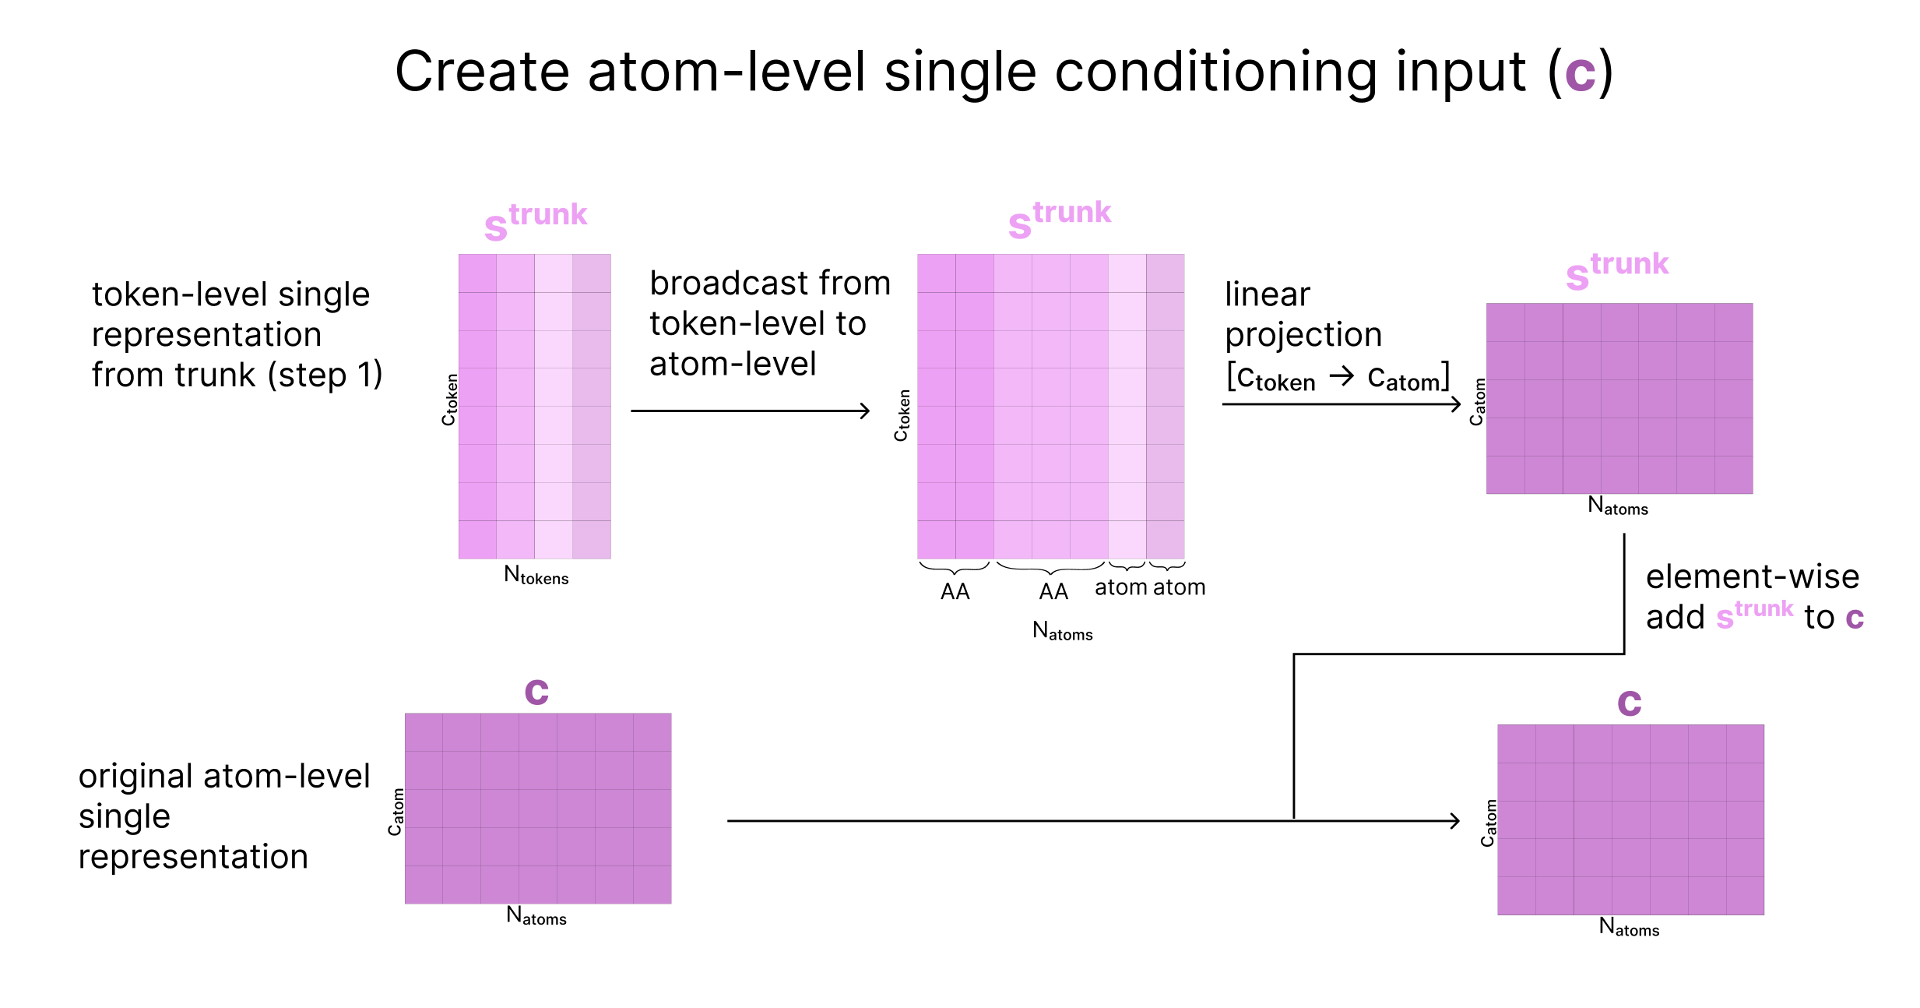

In [9]:
Image(filename="images/af3_21_a.png")

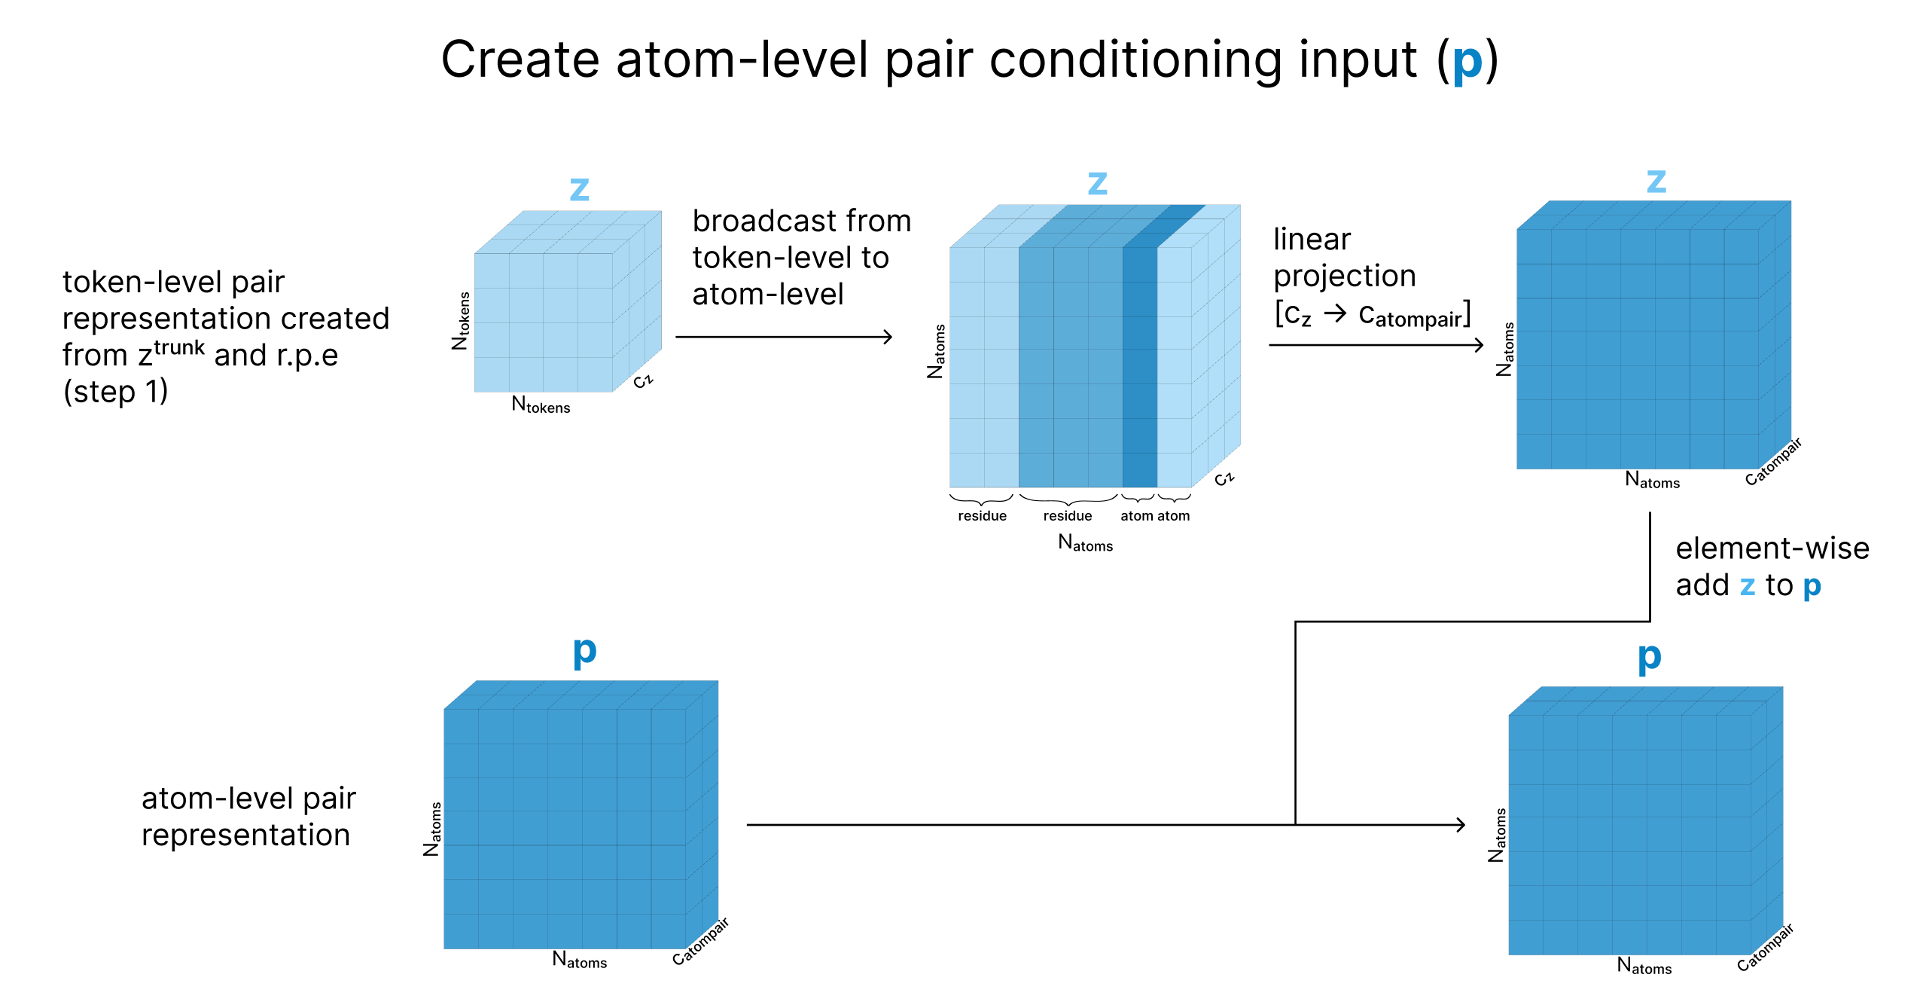

In [10]:
Image(filename="images/af3_21_b.png")

Another advantage of this approach is that once the more computationally intensive "trunk" operations are complete, you can simply sample additional 

In [11]:
width, height = 200, 300
list_pdbs = glob.glob("images/0a3a0cf4-41df-4134-befc-84ac019072ae*.pdb")
list_htmls = []
for pdb in list_pdbs:
    view_temp = py3Dmol.view(width=width, height=height)
    with open(pdb, 'r') as f:
        view_temp.addModel(f.read(), 'pdb')
    view_temp.setStyle({'cartoon': {'color': 'spectrum'}})
    view_temp.zoomTo()
    list_htmls.append(view_temp._repr_html_())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

A limitation of diffusion in AF3 is that particularly long intrinsically disordered regions eventually adopt helical secondary structures.<sup>([4](https://bsky.app/profile/daviddesancho.bsky.social/post/3ldfvzxvwi22f))</sup>

In [12]:
view = py3Dmol.view(width=800, height=800)
view.addModel(open('images/fold_2025_07_30_20_30_model_0.cif', 'r').read(), 'cif')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Kinase inhibitor binding

## Inhibitor classification

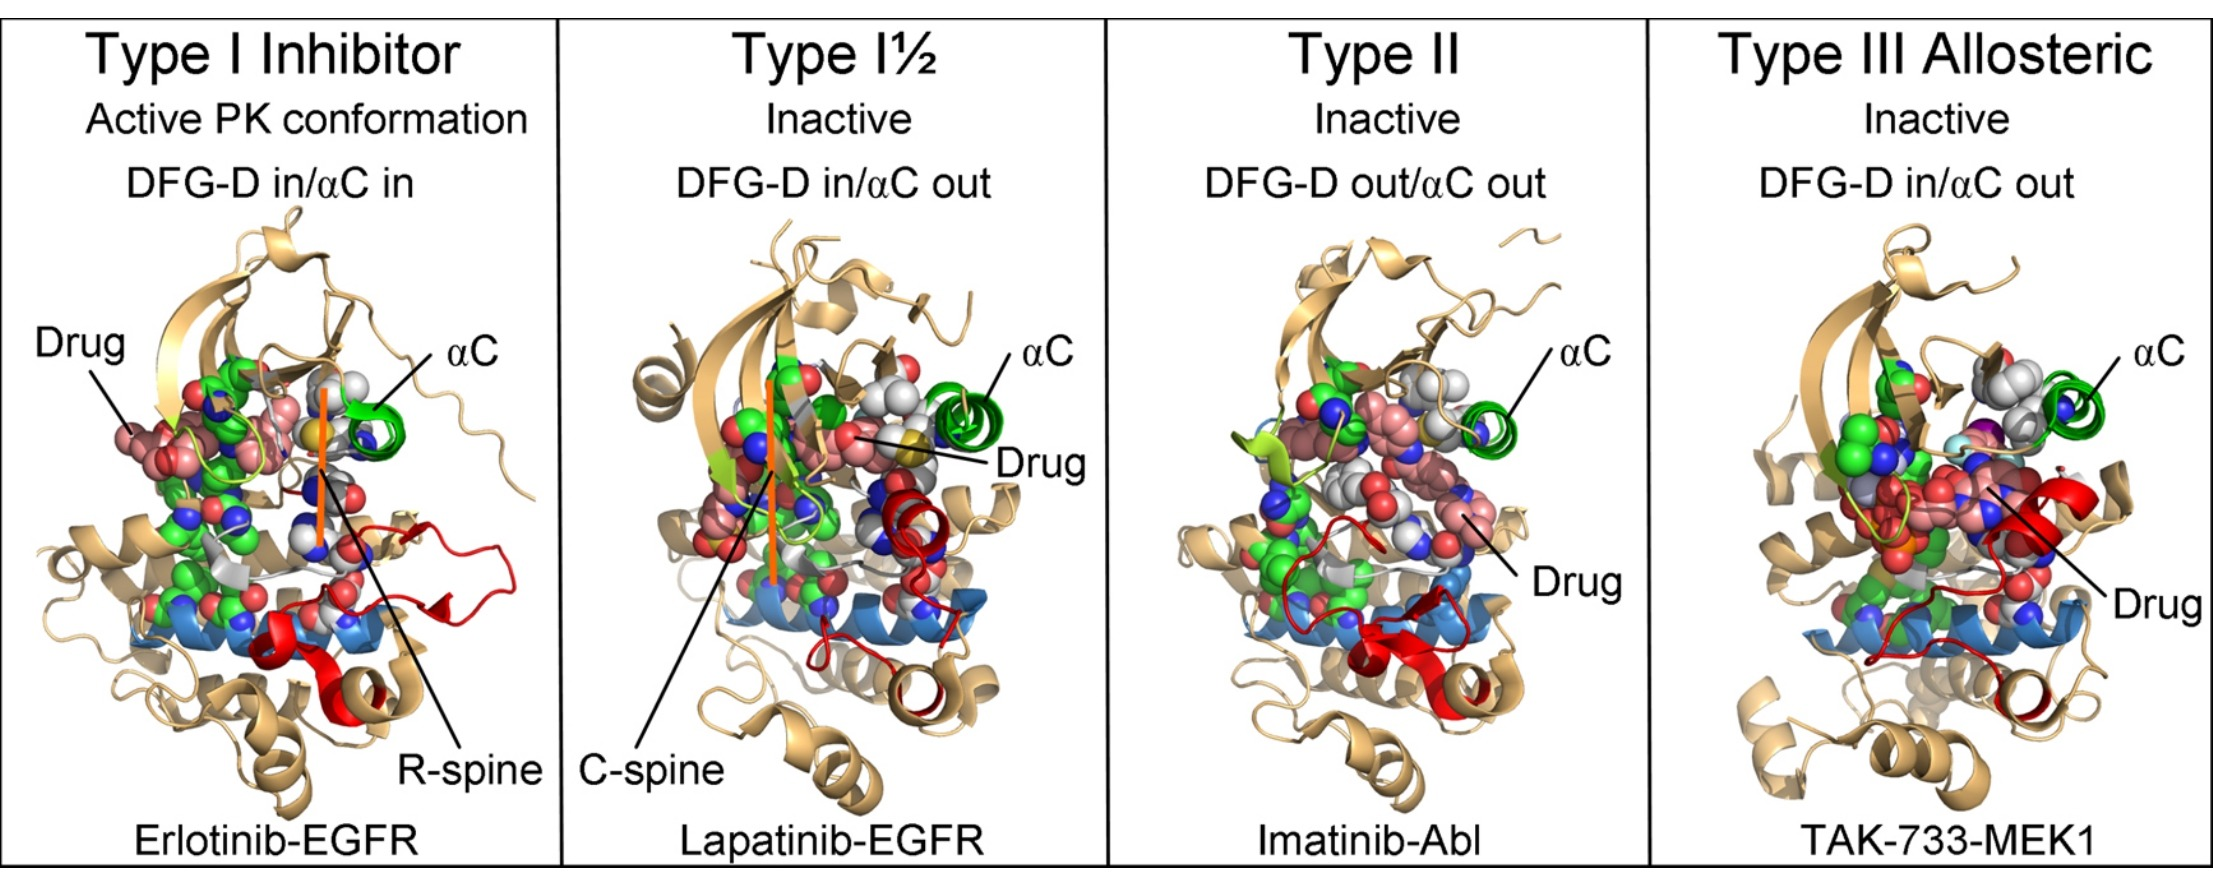

In [13]:
Image("images/roskoski.jpg")

## Orthosteric pocket

We can visualize the relevant residues using [mkt.app](https://mkt-app.streamlit.app/).

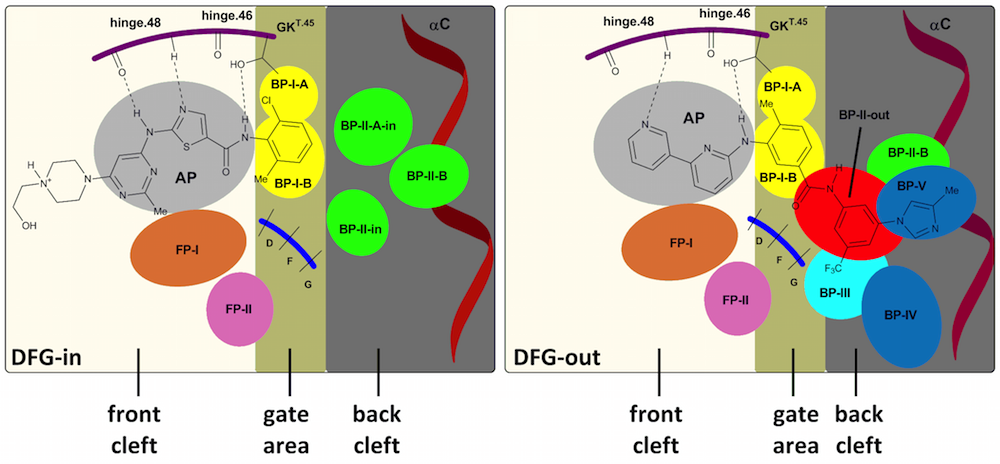

In [14]:
Image("images/klifs_pocket.png")

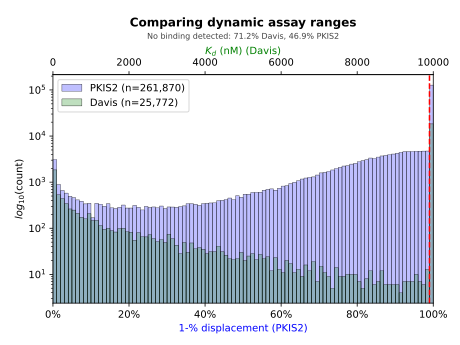

In [15]:
display(SVG("images/DiscoverX_Dynamic_Range_Hist.svg"))

## Using `nextflow` to run `boltz-2`

Preliminary implementation available<sup>[5](https://github.com/choderalab/missense-kinase-toolkit/tree/main/nextflow)</sup>

In [16]:
with open(glob.glob("images/*.yaml")[0], 'r') as stream:
    try:
        yaml_data = yaml.safe_load(stream)
        pretty_string = yaml.dump(yaml_data, default_flow_style=False, sort_keys=False, indent=2)
        print(pretty_string)
    except yaml.YAMLError as exc:
        print(exc)

version: 1
sequences:
- protein:
    id: A
    sequence: DKESFEKAYQVGAVLGSGGFGTVYAGSRIADGLPVAVKHVVKERVTEWGSLGGATVPLEVVLLRKVGAAGGARGVIRLLDWFERPDGFLLVLERPEPAQDLFDFITERGALDEPLARRFFAQVLAAVRHCHSCGVVHRDIKDENLLVDLRSGELKLIDFGSGALLKDTVYTDFDGTRVYSPPEWIRYHRYHGRSATVWSLGVLLYDMVCGDIPFEQDEEILRGRLLFRRRVSPECQQLIRWCLSLRPSERPSLDQIAAHPWMLGADGGVP
- ligand:
    id: B
    smiles: CN1CCN(C(=O)c2cc3cc(Cl)ccc3[nH]2)CC1
properties:
- affinity:
    binder: B

